In [4]:
from main import *
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

# train_dataset = pandas.read_pickle(self.input()[0].path)[['pos', 'pattern_label', 'domain']].values
test_dataset = pandas.read_pickle('/mnt/data40T_v2/rdubois/data/tmp/test_mix_4.5_1.5_smFishSimulations_v2_130k_,smFishSimulations_v3_mRNA25_,smFishSimulations_v4_,smFishSimulations_v5_random_,smFishSimulations_v6_mRNA50_.pkl')[['pos', 'pattern_label', 'domain']].values

num_classes = test_dataset[:, 1].max() + 1

test_generator = datagenerator_DA(test_dataset,
                                                 60,
                                                 num_classes,
                                                 )
n_steps_test = test_dataset.shape[0] // 60

In [14]:
from keras.models import load_model
input_ = Input(shape=(600, 600, 3))
output_ = SqueezeNetOutputDA(input_, num_classes, lam=1., bypass='simple')
sqn_da = Model(input_, output_)
sqn_da.load_weights('/cbio/donnees/rdubois/results/sqnDA_dw_0.3_lam_1.0/model-ckpt')

embedder = Model(input_, [sqn_da.layers[-9].output, sqn_da.layers[-2].output])

In [19]:
Ydomain = []
Ypattern = []
features = []
pred = []
for i in tqdm.tqdm(range(n_steps_test)):
    x, (pat, dom) = next(test_generator)
    Ypattern.append(pat)
    Ydomain.append(dom)
    f, p = embedder.predict(x)
    features.append(f)
    pred.append(p)
    
Ydomain = numpy.argmax(numpy.concatenate(Ydomain), axis=1)
Ypattern = numpy.argmax(numpy.concatenate(Ypattern), axis=1)
features = numpy.concatenate(features)
pred = numpy.argmax(numpy.concatenate(pred), axis=1)


100%|██████████| 122/122 [01:07<00:00,  1.82it/s]


In [20]:
from MulticoreTSNE import MulticoreTSNE
tsne = MulticoreTSNE(n_jobs=24, n_components=2)
plan = tsne.fit_transform(features)

/cbio/donnees/rdubois/miniconda3/envs/keras2/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Tried to set a label via parameter 'y' in func 'scatter' but couldn't find such an argument.
(This is a programming error, please report to the Matplotlib list!)
  del sys.path[0]


,
.
.
.
.


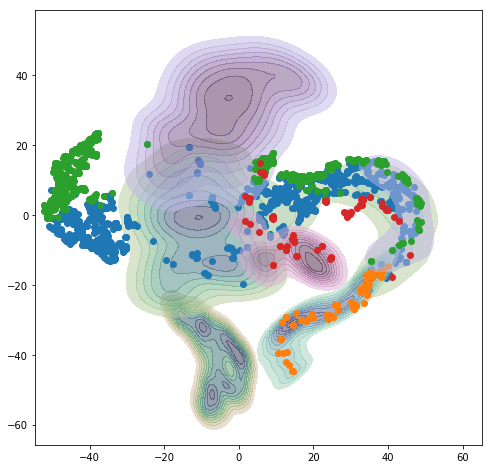

In [53]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(8, 8))
cmap = plt.cm.viridis
for l in numpy.unique(pred):
    sl = (pred==l)
    sns.kdeplot(plan[sl*(Ydomain==0), 0], plan[sl*(Ydomain==0), 1],
               cmap=sns.palettes.cubehelix_palette(start=.5, rot=-1 +l*0.2, as_cmap=True),
               shade=True,
               shade_lowest=False,
               alpha=0.5)
    try:
        ax.scatter(*zip(*plan[sl*(Ydomain==1)]))
        print('.')
    except:
        print(',')
        continue
    

In [48]:
print(plan[(Ypattern==4)*(Ydomain==1)].shape)

(0, 2)


In [50]:
print(numpy.bincount(Ypattern[Ydomain==1]))

[1844]
